   Publishing_Year                                Book_Name  \
0           1975.0                                  Beowulf   
1           1987.0                         Batman: Year One   
2           2015.0                        Go Set a Watchman   
3           2008.0          When You Are Engulfed in Flames   
4           2011.0                 Daughter of Smoke & Bone   
5           2015.0                                Red Queen   
6           2011.0                       The Power of Habit   
7           1994.0  Midnight in the Garden of Good and Evil   
8           2012.0                                 Hopeless   
9           1905.0                        A Little Princess   

                                              Author Language_Code  \
0                             Unknown, Seamus Heaney            en   
1  Frank Miller, David Mazzucchelli, Richmond Lew...            en   
2                                         Harper Lee            en   
3                         

C:\Users\evovtch\AppData\Local\Temp\ipykernel_21192\3941815881.py:79: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Verfilmt'] = df['Verfilmt'].replace({


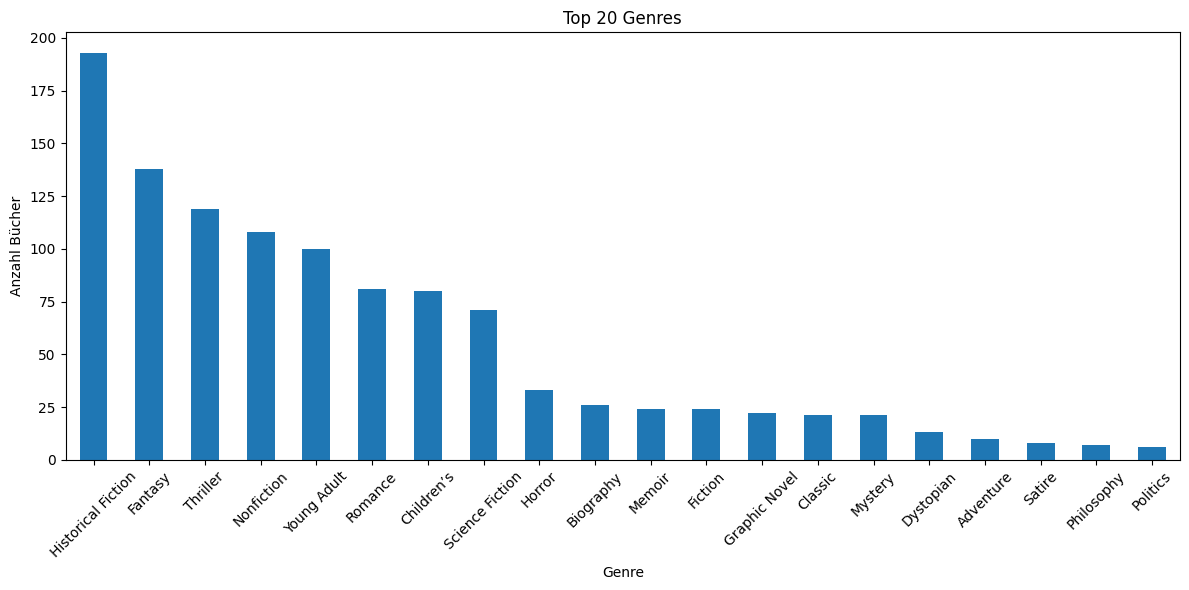

,Publishing_Year,Book_Name,Author,Language_Code,Author_Rating,Book_Average_Rating,Book_Ratings_Count,Gross_sales/ Bruttoumsatz,Publisher_Revenue,Publisher,Verfilmt,Genre_standardized
0,1975.0,Beowulf,"Unknown, Seamus Heaney",en,Novice,3.42,155903.0,34160.0,20496.0,Harper,1.0,Classic
1,1987.0,Batman: Year One,"Frank Miller, David Mazzucchelli, Richmond Lew...",en,Intermediate,4.23,145267.0,12437.5,7462.5,Harper,1.0,Graphic Novel
2,2015.0,Go Set a Watchman,Harper Lee,en,Novice,3.31,138669.0,47795.0,28677.0,"Amazon Digital Services, Inc,",0.0,Historical Fiction
3,2008.0,When You Are Engulfed in Flames,David Sedaris,en,Intermediate,4.04,150898.0,41250.0,24750.0,Hachette,0.0,Nonfiction
4,2011.0,Daughter of Smoke & Bone,Laini Taylor,en,Intermediate,4.04,198283.0,37952.5,22771.5,Penguin,1.0,Fantasy
...,...,...,...,...,...,...,...,...,...,...,...,...
1100,2011.0,Der Fall Collini,Ferdinand von Schirach,de,Intermediate,4.10,15917.0,NaN,6000000.0,Eichborn/Bastei,1.0,Nonfiction
1101,2012.0,Tante Inge haut ab,Dora Heldt,de,Intermediate,3.50,540.0,NaN,6000000.0,btb Verlag,1.0,Romance
1102,2017.0,Tyll,Daniel Kehlmann,de,Intermediate,3.90,14497.0,NaN,12000000.0,dtv,1.0,Historical Fiction
1103,2020.0,Der Heimweg,Sebastian Fitzek,de,Intermediate,4.10,21212.0,NaN,6500000.0,Rowohlt,1.0,Thriller


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from rapidfuzz import process, fuzz

# ---------------------------------------------------------------
# 🔧 Einstellungen für Datei-Import/-Export
# ---------------------------------------------------------------
CSV_INPUT = "buch_basisdaten.csv"
CSV_OUTPUT = "buch_basisdaten_bereinigt_mit_genres.csv"
ENCODING = "utf-8"
SEP = ";"  # Annahme: Daten sind mit Semikolon getrennt

# ---------------------------------------------------------------
# 🧩 Sprache standardisieren (z. B. "eng", "en-US" → "en")
# ---------------------------------------------------------------
language_map = {
    "eng": "en", "en-US": "en", "en-GB": "en", "en-CA": "en", "en-AU": "en",
    "spa": "es", "fre": "fr"
}

def standardize_language(code):
    return language_map.get(code, code)

# ---------------------------------------------------------------
# 🔄 Funktion zur Bereinigung von Zahlenfeldern
# ---------------------------------------------------------------
def clean_number(value, typ="float"):
    if pd.isna(value):
        return None
    try:
        value = str(value)
        value = (
            value.replace("€", "")
                 .replace("Â", "")
                 .replace("\xa0", "")
                 .replace("\x80", "")
                 .replace(" ", "")
                 .replace(".", "")
                 .replace(",", ".")
                 .strip()
        )
        return int(float(value)) if typ == "int" else float(value)
    except Exception as e:
        print(f"⚠️ Fehler bei Wert: {repr(value)} → {e}")
        return None

# ---------------------------------------------------------------
# 🧠 Genre-Normalisierung mit fuzzy matching
# ---------------------------------------------------------------
standard_genres = [
    "Fantasy", "Science Fiction", "Thriller", "Mystery", "Historical Fiction",
    "Romance", "Fiction", "Biography", "Memoir", "Children’s", "Young Adult",
    "Nonfiction", "Horror", "Adventure", "Philosophy", "Politics", "Satire",
    "Graphic Novel", "Dystopian", "Classic",
]

def generate_genre_mapping(unique_genres):
    mapping = {}
    for genre in unique_genres:
        if pd.isna(genre) or genre == "":
            mapping[genre] = genre
            continue
        result = process.extractOne(genre, standard_genres, scorer=fuzz.token_sort_ratio)
        if result and result[1] > 30:
            mapping[genre] = result[0]
        else:
            mapping[genre] = genre
    return mapping

# ---------------------------------------------------------------
# 🧼 Hauptfunktion zur vollständigen Datenbereinigung
# ---------------------------------------------------------------
def clean_book_data(df):
        # Verfilmung vereinheitlichen
# Verfilmung in binär (1 = Ja, 0 = Nein, None = unklar) umwandeln
    if "Verfilmt" in df.columns:
        df['Verfilmt'] = df['Verfilmt'].astype(str).str.lower().str.strip()
        df['Verfilmt'] = df['Verfilmt'].replace({
            "ja": 1, "ja?": 1, "yes": 1,
            "nein": 0, "no": 0,
            "-": None, "unclear": None, "nan": None, "": None
        })
        df['Verfilmt'] = df['Verfilmt'].astype("float")  # als numerischer Wert für Analyse/ML
    # Sprache vereinheitlichen
    df['Language_Code'] = df['Language_Code'].apply(standardize_language)

    # Genre-Mapping erstellen und anwenden
    if "Genre_new" in df.columns:
        unique_genres = df['Genre_new'].dropna().unique()
        genre_mapping = generate_genre_mapping(unique_genres)
        df['Genre_standardized'] = df['Genre_new'].map(genre_mapping)
    else:
        df['Genre_standardized'] = None

    # Relevante Spalten numerisch bereinigen
    numeric_columns = {
        "Gross_sales/ Bruttoumsatz": "float",
        "Publisher_Revenue": "float",
        "Book_Average_Rating": "float",
        "Book_Ratings_Count": "int"
    }

    for col, typ in numeric_columns.items():
        if col in df.columns:
            df[col] = df[col].apply(lambda x: clean_number(x, typ))

    # Entferne Bücher mit unrealistischen Jahresangaben (vor Jahr 1000)
    if "Publishing_Year" in df.columns:
        df = df[df["Publishing_Year"] >= 1000]

    # Überflüssige Spalten löschen
    df = df.drop(columns=["Unnamed: 12", "Genre_new"], errors="ignore")

    # Index zurücksetzen nach Filterung
    return df.reset_index(drop=True)

# ---------------------------------------------------------------
# 🚀 Skript-Ausführung: Daten laden, bereinigen, speichern
# ---------------------------------------------------------------
def main():
    try:
        df = pd.read_csv(CSV_INPUT, encoding='latin1', sep=SEP)
        print(f"📄 Datei geladen: {CSV_INPUT}")
    except Exception as e:
        print(f"❌ Fehler beim Laden der Datei: {e}")
        return

    df = clean_book_data(df)

    try:
        df.to_csv(CSV_OUTPUT, index=False, encoding=ENCODING, sep=SEP)
        print(f"✅ Bereinigte Datei gespeichert unter: {CSV_OUTPUT}")
    except PermissionError:
        fallback = "buch_basisdaten_output_fallback.csv"
        df.to_csv(fallback, index=False, encoding=ENCODING, sep=SEP)
        print(f"⚠️ Ursprüngliche Datei blockiert. Gespeichert als: {fallback}")

    # Vorschau auf bereinigte Daten
    print("\n📊 Datenvorschau:")
    print(df.head())

    print("\n🧾 Spaltenübersicht:")
    print(df.info())

    print("\n📈 Statistikübersicht:")
    print(df.describe(include='all'))

    # Optional: Verteilung der Genres anzeigen
    if "Genre_standardized" in df.columns:
        print("\n🎭 Häufigste Genres:")
        print(df["Genre_standardized"].value_counts().head(10))

# Anzeigeoptionen anpassen (alle Spalten sichtbar)
df = pd.read_csv("buch_basisdaten_bereinigt_mit_genres.csv", sep=";", encoding="utf-8")
pd.set_option('display.max_columns', None)

# Zeige die ersten 10 Zeilen
print(df.head(10))
# ---------------------------------------------------------------
# 🧪 Ausführung
# ---------------------------------------------------------------
if __name__ == "__main__":
    main()


# Anzeigeoptionen anpassen (alle Spalten sichtbar)
df = pd.read_csv("buch_basisdaten_bereinigt_mit_genres.csv", sep=";", encoding="utf-8")
pd.set_option('display.max_columns', None)

# Zeige die ersten 10 Zeilen
print(df.head(10))

print("Anzahl verschiedener Genres:", df['Genre_standardized'].nunique())
print("Beispielhafte Genres:", df['Genre_standardized'].dropna().unique()[:20])



import matplotlib.pyplot as plt

df['Genre_standardized'].value_counts().head(28).plot(kind='bar', figsize=(12,6), title="Top 20 Genres")
plt.xlabel("Genre")
plt.ylabel("Anzahl Bücher")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
df